# Домашнее задание 2

В этом домашнем задании мы поупражняемся с ETS-моделью и STL-разложением. Сначала коротко про данные.

Представьте себе стандартный банкомат, который работает только на выдачу. Его нужно периодически пополнять наличностью, чтобы он функционировал непрерывно. Однако выезд инкассаторов является делом хлопотным и недешёвым, так что хотелось бы не гонять их лишний раз заполнять наполовину полный банкомат. Хотелось бы научиться предсказывать спрос людей на наличность в банкомате, чтобы можно было предсказывать время, когда количество денег в банкомате снизится до минимально допустимой величины. Этим мы и займёмся. Для простоты возьмём один конкретный банкомат. Нам доступны объёмы выдачи в банкомате по дням.

In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import STL


from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (23,9)

##### 1) Загрузка данных и визуальный анализ (1 балл)

Важно! sktime довольно капризен в плане форматов даты-времени. Для работы некоторых функций может требоваться PeriodIndex или DateTimeIndex. Часто самые непонятные ошибки происходят из-за этого. К сожалению, на текущий момент это данность, но мы в вас верим.

Загрузите данные из файла atm.csv. Изобразите временной ряд, его автокорреляции (можно ещё автокорреляции первых разностей для большей ясности).  Что вы можете сказать о структуре ряда? Присутствует ли в нём тренд? Сезонность? Цикличность? Опишите, как сделанные вами наблюдения помогут построить модель.

In [10]:
atmdf = pd.read_csv('atm.csv')
atmdf.head()
atmdf = atmdf.rename(columns={'Unnamed: 0':'Date'})
atmdf.Date = pd.to_datetime(atmdf.Date)
atmdf = atmdf.set_index('Date')
atmdf

,target
Date,
2015-01-01,213400.0
2015-01-02,94500.0
2015-01-03,63900.0
2015-01-04,134900.0
2015-01-05,99800.0
...,...
2017-09-08,165600.0
2017-09-09,97000.0
2017-09-10,81000.0


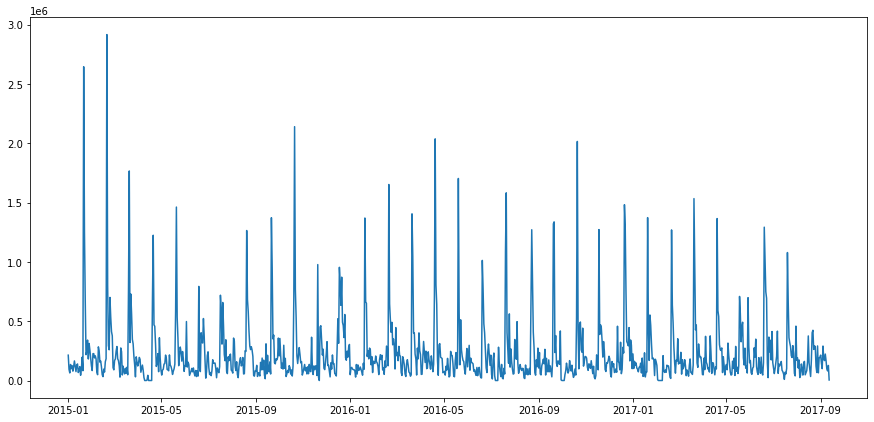

In [21]:
plt.figure(figsize=(15, 7))
plt.plot(atmdf);

Структура ряда: Ряд является стационарным. Каждый месяц повышается, а затем возвращается к своим привычным значением близким к нулю.

In [102]:
atmdf[atmdf.target > atmdf.quantile(0.99).values[0]]

,target
2015-01-21,2644100.0
2015-02-20,2915200.0
2015-03-21,1765800.0
2015-10-21,2139200.0
2016-02-20,1651700.0
2016-04-20,2036300.0
2016-05-20,1702600.0
2016-07-21,1581400.0
2016-10-21,2014500.0
2017-03-21,1532900.0


In [110]:
atmdf.diff()[atmdf.target.diff() < atmdf.diff().quantile(0.01).values[0]]

,target
2015-01-22,-1391400.0
2015-02-21,-2112000.0
2015-03-22,-1445800.0
2015-10-22,-1370200.0
2016-02-21,-1007600.0
2016-04-21,-1228800.0
2016-05-21,-1118300.0
2016-07-22,-1176800.0
2016-09-22,-1101100.0
2016-10-22,-1590200.0


Явно наблюдается месячная тенденция к сильному скачку в 20-х числах каждого месяца, при этом на следующий день после этого скачка следует просадка такой же силы. Следовательно, цикличность в данном случае будет месячной.

Возможно, в 20-е числа каждого месяца приходит инкассатор и пополняет банкомат. На следующий же день люди приходят снимать свои зарабатные платы и пенсии, поэтому наличность в значительной степени падает. 

Сезонности нет.

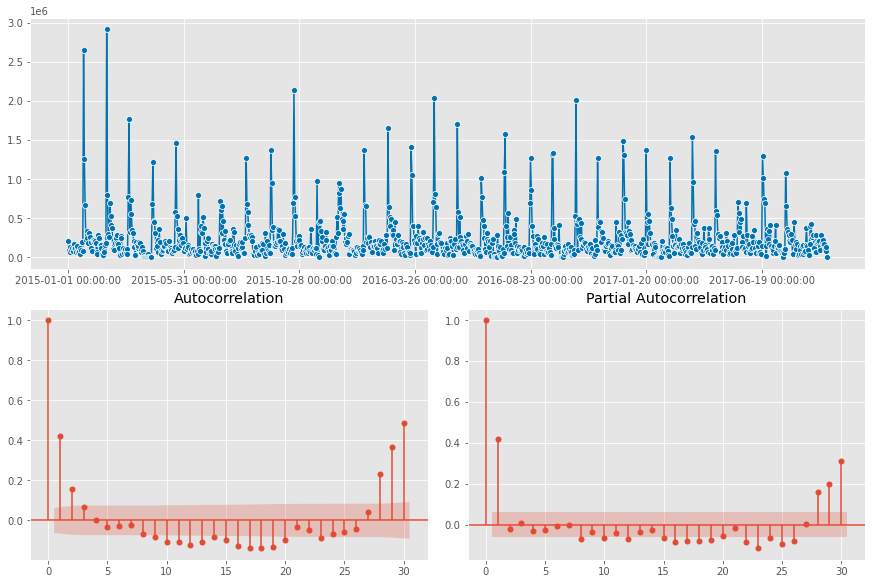

In [189]:
plot_correlations(atmdf, 30);

Тренд не обнаружен.

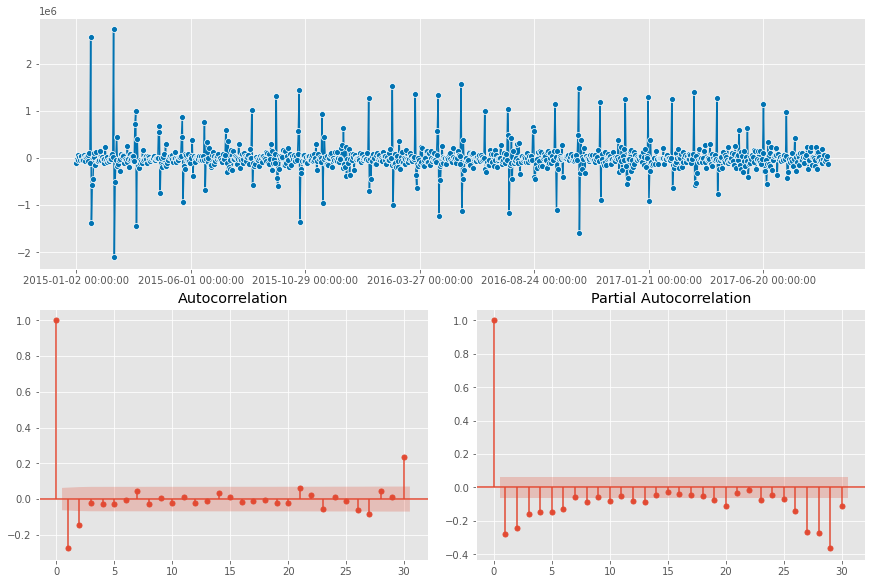

In [190]:
plot_correlations(atmdf.diff().dropna(), 30);

С помощью полученной информации можно будет сделать модель с месячной сезенностью, при этом нужно будет попытаться избавиться от явных "выбросов", чтобы сделать структуру более однородной.

##### 2) Предобработка данных (0.5 балла)

Разбейте данные на трейн и тест. Размер теста: последние 50 дней.

Как легко заметить, данные неотрицательны. Но на случай использования мультипликативных моделей рекомендуется децентировать трейн в положительную полуось. Дополнительно можете произвести на трейне обратимые преобразования, которые сочтёте необходимыми (Box-Cox, детрендирование и т.п.).

In [33]:
train = atmdf[:-50]
test = atmdf.tail(50)

/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:903: RuntimeWarning: divide by zero encountered in log
  logdata = np.log(data)
/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/morestats.py:912: RuntimeWarning: divide by zero encountered in power
  variance = np.var(data**lmb / lmb, axis=0)
/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


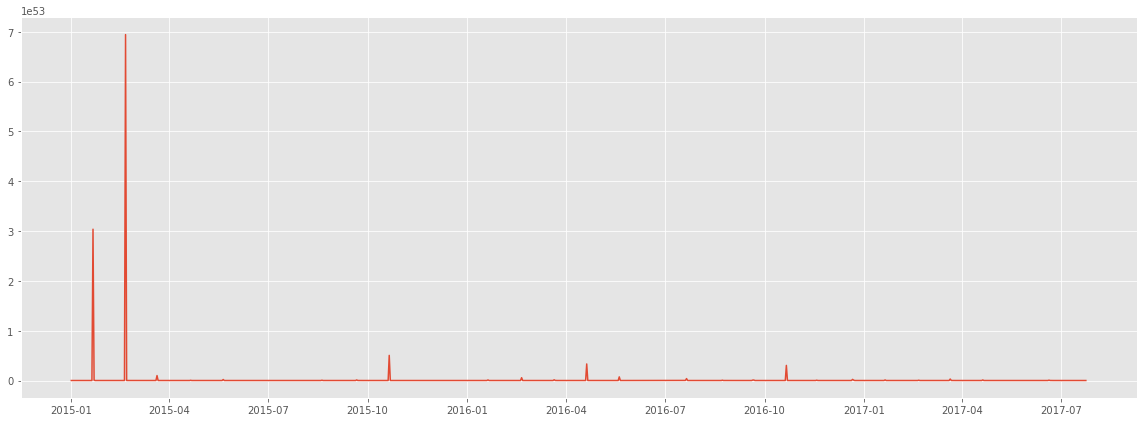

In [76]:
from sktime.transformations.series.boxcox import BoxCoxTransformer
boxcox = BoxCoxTransformer()

train_bc = boxcox.fit_transform(train)
test_bc = boxcox.transform(test)

plt.figure(figsize=(20, 7))
plt.plot(train_bc);

In [50]:
boxcox.lambda_

8.472135811722177

### Блок 1. STL/MSTL


Здесь и далее будем работать только с трейном. В данном разделе мы попробуем декомпозировать ряд с помощью STL или MSTL. В этом случае наш ряд можно представить в следующем виде:

$$y^{train}_t = t_t + s_t + e_t$$

 $t_t$ - компонента трейна

 $s_t$ - компонента сезонности, в случае MSTL будет несколько компонент сезонности
 
 $e_t$ - компонента остатков


Для каждой компоненты мы будем оценивать отдельную многошаговую модель. Компоненты тренда и сезонности обычно простые по своей структуре. Для них мы будем использовать какие-нибудь тривиальные модели. Компонента остатков обычно самая сложная, так как включает в себя "всё остальное". Для неё мы будем строить модель с признаками аналогично ДЗ-1.

Каждую компоненту необходимо будет многошагово спрогнозировать на тестовый период. Так как STL-разложение аддитивно, прогнозы мы просто просуммируем.

$$\hat{y}^{test}_t = \hat{t}_t + \hat{s}_t + \hat{e}_t$$

Таким образом мы получим итоговый прогноз.


##### Разложение (0.3 балла)

Начнём с STL. Примените на трейне STL или MSTL-разложение (обоснуйте выбор). Обоснуйте период(ы), который вы берёте в качестве сезонного. Визуализируйте отдельные компоненты.

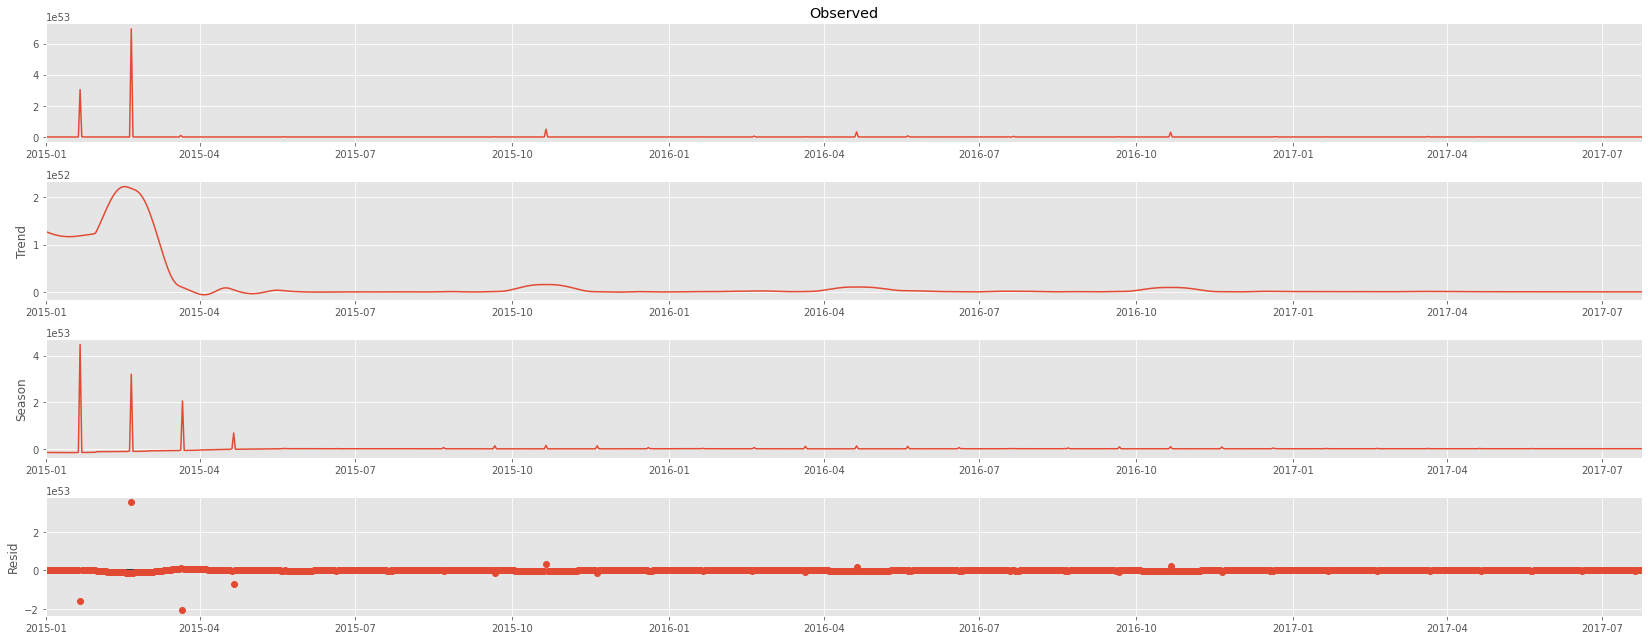

In [209]:
res = STL(train_bc, period=30).fit()
res.plot();

/Users/olegchernikov/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


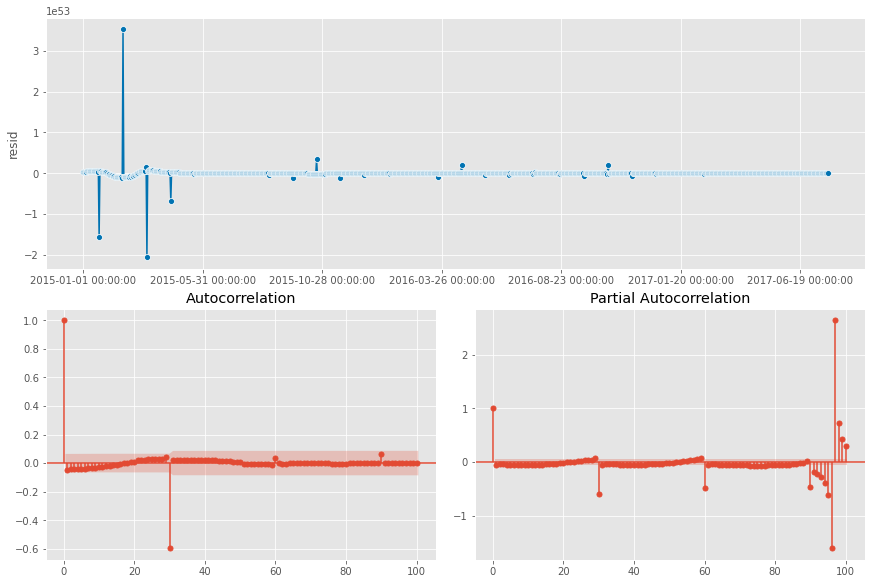

In [210]:
plot_correlations(res.resid, 100);

##### Прогнозирование тренда (0.3 балла)

Достаньте из оценённой модели компоненту тренда. Спрогнозируйте этот ряд на длину теста любой простой моделью в зависимости от вида ряда (Наивная, RandomWalk, любой алгоритм сглаживания, ...).

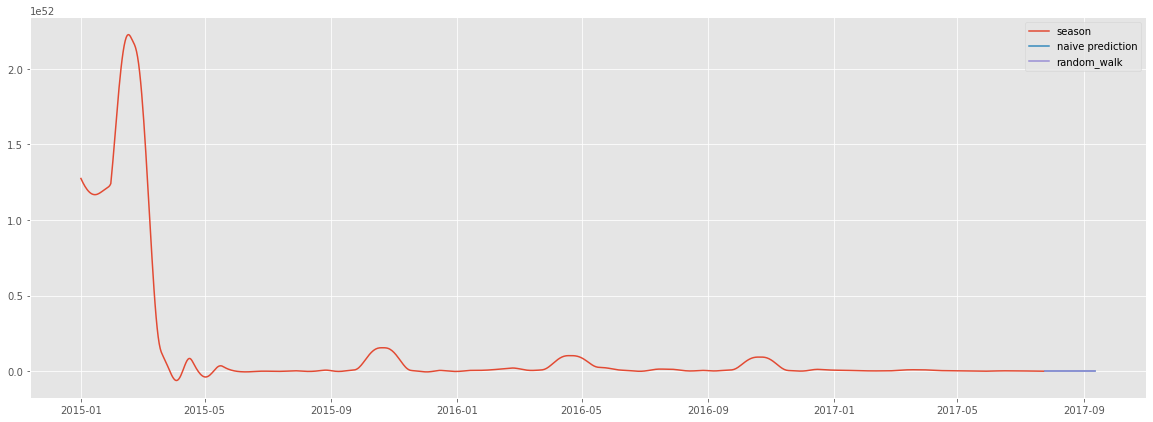

In [211]:
np.random.seed(42)

trend = res.trend

naive = trend[-1]
naive = pd.Series(index=test.index, data=naive)

random_walk = [trend[-1]]
for i in range(1, test.shape[0]):
    movement = -10000 if np.random.rand() > 0.5 else 10000
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
random_walk = pd.Series(index=test.index, data=random_walk)

plt.figure(figsize=(20, 7))
plt.plot(trend)
plt.plot(naive)
plt.plot(random_walk)
plt.legend(['season', 'naive prediction', 'random_walk', 'test']);

##### Прогнозирование сезонности (0.3 балла)

Достаньте из модели компоненту или компоненты сезонности. Аналогично спрогнозируйте любой простой моделью без фичей.

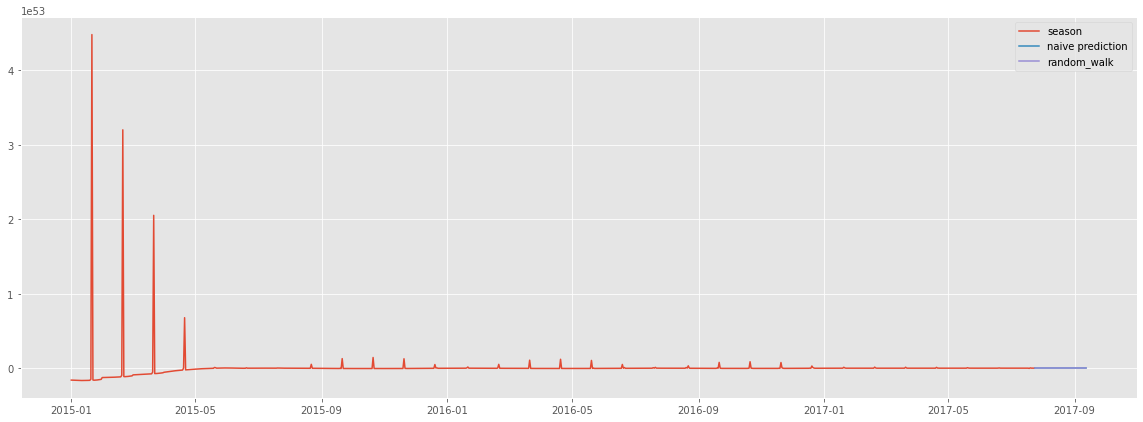

In [212]:
np.random.seed(43)

season = res.seasonal

naive_season = season[-1]
naive_season = pd.Series(index=test.index, data=naive_season)

random_walk = [season[-1]]
for i in range(1, test.shape[0]):
    movement = -100000 if np.random.rand() > 0.5 else 100000
    value = random_walk[i-1] + movement
    random_walk.append(value)
    
random_walk = pd.Series(index=test.index, data=random_walk)

plt.figure(figsize=(20, 7))
plt.plot(season)
plt.plot(naive_season)
plt.plot(random_walk)
plt.legend(['season', 'naive prediction', 'random_walk']);

#### Прогнозирование остатков. 

Теперь возьмёмся за самую сложную часть, прогнозирование компоненты остатков. Достаньте из модели эту компоненту.


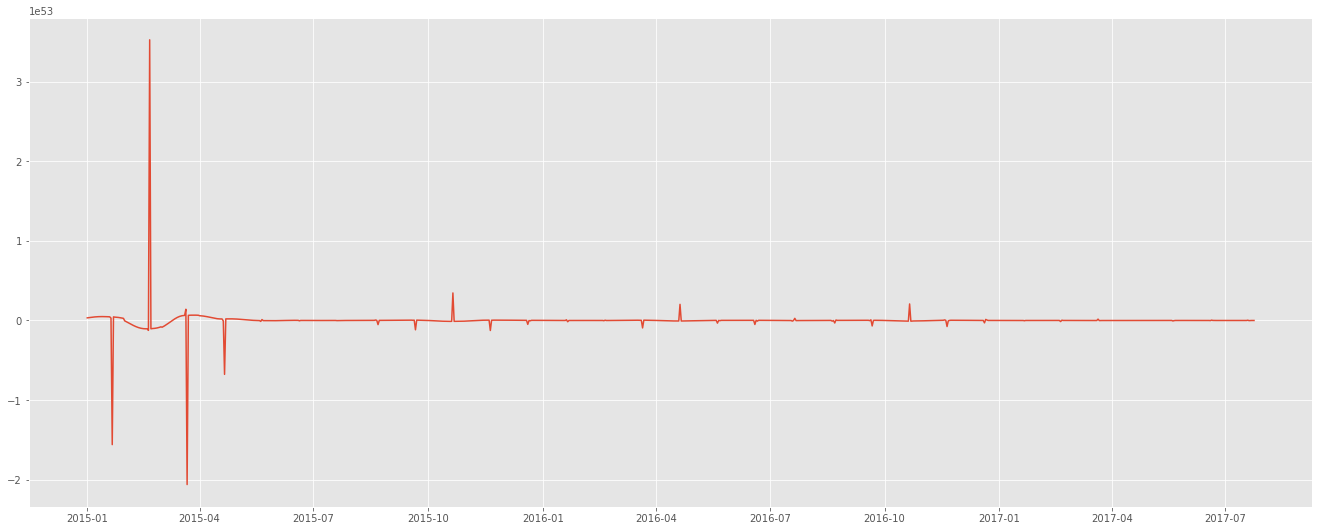

In [213]:
residuals = res.resid
plt.plot(residuals);


##### Подготовка данных (0.9 балла)

Многошаговый прогноз остатков потребует уже модели с фичами. По сути эта задача эквивалентна многошаговому прогнозированию из ДЗ-1. Стратегия многошагового прогнозирования и выбор модели также остаётся на ваше усмотрение. В текущем пункте вам необходимо подготовить фичи для модели. В этот раз вам не будет дано конкретных указаний по генерации переменных. Но будет выдана дополнительная информация о банкомате. Можете её использовать, можете нет, на ваше усмотрение. 

Расположение: ул Крымский Вал, 9стр45

Дополнительная информация: ГАУК культуры города Москвы ЦПКиО им. М.Горького

Широта: 55.73259

Долгота: 37.600891

Также в помощь прилагается файл с различными календарными фичами (events.csv), чтобы не повторять в этой домашке то же самое, что в прошлой. Можете использовать любые фичи из этого файла, но для засчитывания пункта необходимо придумать минимум три фичи (по 0.3 за каждую), не входящие в приложенный файл. Каждую используемую фичу (не важно, из файла или придуманную вами) необходимо кратко обосновать. Не забывайте учитывать потенциальные утечки. За их наличие балл также может быть снижен.

Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [176]:
eventsdf = pd.read_csv('events.csv')
eventsdf = eventsdf.rename(columns={'Unnamed: 0':'Date'})
eventsdf.Date = pd.to_datetime(eventsdf.Date)
eventsdf = eventsdf.set_index('Date')
eventsdf.tail()

,выходной,праздник,короткий рабочий день,предпраздничный рабочий день,предвыходной рабочий день,последний день месяца,пн,вт,ср,чт,...,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,предвыходной
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,0,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0
2017-12-28,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0.0,1.0,0.0,0.0,0.0,0
2017-12-29,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0.0,0.0,1.0,0.0,0.0,0
2017-12-30,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0.0,0.0,0.0,1.0,0.0,0
2017-12-31,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0.0,0.0,0.0,0.0,1.0,0


In [181]:
eventsatmdf = pd.merge(atmdf, eventsdf, left_index=True, right_index=True, how='left')
eventsatmdf.head()

,target,выходной,праздник,короткий рабочий день,предпраздничный рабочий день,предвыходной рабочий день,последний день месяца,пн,вт,ср,...,сентябрь,октябрь,ноябрь,декабрь,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,предвыходной
2015-01-01,213400.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2015-01-02,94500.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2015-01-03,63900.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2015-01-04,134900.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0
2015-01-05,99800.0,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0


In [197]:
# новые фичи:

eventsatmdf['shift_30'] = eventsatmdf.target.shift(30)
eventsatmdf = eventsatmdf.dropna()
t = np.arange(eventsatmdf.shape[0])+1
eventsatmdf['sin_30'] = np.sin(t * np.pi * 2 / 30) # синус на месяц
eventsatmdf['cos_30'] = np.cos(t * np.pi * 2 / 30) # косинус на месяц
eventsatmdf['peaks'] = [1 if day in [18, 19, 20, 21, 22] else 0 for day in eventsatmdf.index.day]

/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_34397/3958920562.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventsatmdf['sin_30'] = np.sin(t * np.pi * 2 / 30) # синус на месяц
/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_34397/3958920562.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventsatmdf['cos_30'] = np.cos(t * np.pi * 2 / 30) # косинус на месяц
/var/folders/7c/f8xjv4ln3gscgmy55z3877_40000gn/T/ipykernel_34397/3958920562.py:8: SettingWithCopyWarning: 
A value is 

In [199]:
eventsatmdf.head()

,target,выходной,праздник,короткий рабочий день,предпраздничный рабочий день,предвыходной рабочий день,последний день месяца,пн,вт,ср,...,27-Дек,28-Дек,29-Дек,30-Дек,31-Дек,предвыходной,shift_30,sin_30,cos_30,peaks
2015-01-31,124000.0,1,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,213400.0,0.207912,0.978148,0
2015-02-01,83700.0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0,94500.0,0.406737,0.913545,0
2015-02-02,226400.0,0,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0,63900.0,0.587785,0.809017,0
2015-02-03,226300.0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0,134900.0,0.743145,0.669131,0
2015-02-04,190300.0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0,99800.0,0.866025,0.500000,0


In [207]:
from sklearn.model_selection import train_test_split

y_e = eventsatmdf['target']
X_e = eventsatmdf.drop(columns='target')
size = 50/X_e.shape[0]

e_X_train, e_X_test, e_train, e_test = train_test_split(X_e, y_e, test_size=size, random_state=0, shuffle=False)

#### Кросс-валидация

Теперь займёмся подбором оптимальной модели остатков. Для этого используем кросс-валидацию.

##### Реализация метода (0.6 балла)

Реализуйте метод скользящего окна. Реализуйте класс, который будет по входным параметрам окна выдавать индексы всех фолдов. По поведению можно ориентироваться на знакомый вам k-fold. Хорошей практикой будет возвращать в методе split генератор, хотя это и не обязательно. На каждом фолде модель будет обучаться на трейне и делать многошаговый прогноз на тест. 

Позаботьтесь о том, чтобы ширина окна была соотнесена в логичной пропорции с горизонтом прогнозирования. Длина трейна 55 при горизонте 50 -- сомнительная практика.


In [252]:
import pandas as pd

class CustomCrossVal:
    def __init__(self, window_size:int, step:int):

        '''Args:
            window_size (int): The size of window. For expanding window -- initial size of window
            step (int): Window step. For expanding window is a growth of window. For sliding window is number of obs to slide.
        '''
        self.window_size = window_size
        self.step = step

    def split(self, y:pd.Series, X: pd.DataFrame):
        '''Args:
            X (pandas DataFrame): Dataframe to split.
           '''
        y_train_batch = []
        X_train_batch = []
        y_test_batch = []
        X_test_batch = []
        
        start_train = 0
        stop_train = 2 * self.window_size
        start_test = 2 * self.window_size
        stop_test = 3 * self.window_size
        
        while X.shape[0] - stop_test >= self.step:
        
            y_train_batch.append(y.iloc[start_train:stop_train])
            X_train_batch.append(X.iloc[start_train:stop_train])
            y_test_batch.append(y.iloc[start_test:stop_test])
            X_test_batch.append(X.iloc[start_test:stop_test])
            
            start_train += self.step
            stop_train += self.step
            start_test += self.step
            stop_test += self.step
        
        y_train_batch.append(y.iloc[start_train:stop_train])
        X_train_batch.append(X.iloc[start_train:stop_train])
        y_test_batch.append(y.iloc[start_test:X.shape[0]])
        X_test_batch.append(X.iloc[start_test:X.shape[0]])
        
        return y_train_batch, X_train_batch, y_test_batch, X_test_batch

In [253]:
cv = CustomCrossVal(100, 50)
y_train_batch, X_train_batch, y_test_batch, X_test_batch = cv.split(e_train, e_X_train)

##### Отбор моделей (0.5 балла)

Выберите несколько моделей-кандидатов исходя из свойств ряда (обоснуйте) и отберите с помощью реализованной вами кросс-валидации наилучшую. Можно использовать разные модели либо разные наборы фичей. Метрика: MAE.

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Прогноз моделей (0.5 балла)

Обучите наилучшую модель остатков на всём трейне и постройте прогноз на тестовый период, используя выбранную вами многошаговую стратегию.

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Результаты и визуализация (0.6 балла)

Соберите в сумму прогнозы всех компонент STL-разложения на тесте. Не забудьте на сумму прогнозов компонент применить преобразования, обратные тем, которые были сделаны на трейне.  Визуализируйте прогноз и тестовые данные. Подсчитайте MAE прогноза.

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Бэктестинг (0.75 балла)

Попробуем протестировать in-sample итоговую модель, которая получилась. Для этого нам необходимо получить остатки суммарной модели на трейне. Для этого нам необходимо вернуться к моделям отдельных компонент и построить одношаговые прогнозы на всём участке train.

$$e^{clean}_t = y^{train}_t - (\hat{t}^{train}_t + \hat{s}^{train}_t + \hat{e}^{train}_t)$$

Нарисуйте графики автокорреляций этих остатков. Есть ли в каких-то интересных датах значимые пики? Как думаете, с чем эти ошибки модели связаны? (0.5 балла)

Проведите тест Ljung-Box. Протестируйте остатки на наличие серийных автокорреляций при нескольких m. Проинтерпретируйте результаты теста $\alpha = 0.05$. (0.25 балла)

Если нулевая гипотеза отвергается, можете попытаться улучшить модель и поискать фичи по графикам автокорреляций, но это опционально. В ряде ситуаций становится сложно построить модель, в которой гипотеза не отвергается, поэтому иногда на наличие автокорреляций закрывают глаза.

In [ ]:
# ༼ つ ◕_◕ ༽つ

### Блок 2. ETS-модель

Теперь повторим то же самое, только моделировать тренд и сезонность будем ETS-моделью, а на остатки ETS-модели навешивать вторую модель.

$$y^{train}_t = y^{ETS}_t + e^{ETS}_t$$


##### Визуальный анализ (1 балл)

Вернитесь к y_train. Взгляните на ряд и опишите, какие из вариантов ETS-модели подошли бы под наши данные. Сформируйте сетку параметров для моделей-кандидатов. Кратко поясните каждую опцию, которую вы включаете в сетку, основываясь на визуальном анализе.

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Кросс-валидация (0.3 балла)

С помощью кросс-валидации выберите наилучшую по MAE ETS-модель. Обучите её на всём трейне и спрогнозируйте на тест. 

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Подготовка данных (0.1 балла)

Достаньте остатки ETS-модели на трейне.
            $$e_{ETS} = y_{train} - \hat{y}_{train}$$

Это можно сделать с помощью метода predict_residuals. Построим на временном полученном временном ряде многошаговую модель. Можно использовать те же фичи, что и в разделе про STL, без дополнительных пояснений. Если вводите новые фичи, коротко поясните каждую. Результатом пункта должны быть вектор e_train и матрица e_X_train для модели остатков.

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Отбор моделей и кросс-валидация (0.5 баллов)

Отберите несколько моделей-кандидатов для прогнозирования остатков и отберите на кросс-валидации наилучшую по MAE модель. Размер валидации на каждом фолде всё также равен длине тестовой выборки. Используйте реализованный ранее класс для кросс-валидации. 

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Прогноз остатков ETS (0.5 баллов)
Обучите наилучшую модель на всём наборе остатков трейна. Постройте прогноз на тест с помощью любой многошаговой стратегии.

Суммируйте прогнозы двух компонент в итоговый прогноз. Не забудьте в конце наложить обратные преобразования ряда, если вы их делали в самом начале.

$$\hat{y}^{test}_t = \hat{y}^{ETS}_t + \hat{e}^{ETS}_t$$

Подсчитайте MAE.


In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Бэктестинг (0.5 балла)

Найдите остатки одношаговых моделей на тренировочной выборке.

$$e^{cleaned}_t = y^{train}_t - (\hat{y}^{ETS}_t + \hat{e}^{ETS}_t) $$

Так как получить одношаговые прогнозы $\hat{y}^{ETS}_t$ класс из Sktime почему-то не позволяет. Но мы помним, что 

 $$e_{ETS} = y^{train}_t - \hat{y}^{train}_t$$
 
Это выражение можно развернуть и получить искомое.

$$\hat{y}^{ETS}_t = y^{train}_t - e_{ETS}$$

А $e_{ETS}$ мы уже получали с помощью predict_residuals

Таким образом вы получите финальные остатки вашей двухуровневой модели. Нарисуйте графики автокорреляций этих остатков, проинтерпретируйте. Протестируйте их на наличие серийных автокорреляций тестом Ljung-Box.

In [ ]:
# ༼ つ ◕_◕ ༽つ

#### Сравнение моделей

##### Визуальный анализ (0.2 балла)

Визуализируйте прогнозы STL, ETS и тестовые значения на графике. Добавьте небольшой отрезок тренировочных данных, так получится более приятный график. Сравните метрики прогнозов. Какая из двух моделей получилась лучше? Как думаете, почему? 

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Сравнение  моделей (0.65 балла)

(0.2 балла) Возьмите бенчмарк в виде сезонной наивной модели, подобрав период сезонности. Постройте прогноз такой модели на тест и подсчитайте MAE. Преодолела ли хотя бы одна модель этот бенчмарк?

In [ ]:
# ༼ つ ◕_◕ ༽つ

(0.15 балла за каждый корректно проведённый тест)

Проведите односторонний тест Диболда-Мариано для всех трёх возможных пар моделей. STL против ETS, STL против сезонной наивной, ETS против сезонной наивной. Нулевую гипотезу выберите самостоятельно, но тест должен быть односторонним. Готовую функцию с семинара используйте только для расчёта статистики, p-value подсчитайте для ваших гипотез самостоятельно. Проинтерпретируйте результаты всех трёх тестов. 

In [ ]:
# ༼ つ ◕_◕ ༽つ

##### Что бы вы сделали, будь у вас неприлично много денег? (0.05 балла)

P.S. Ваш семинарист хотел бы слетать в космос.

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7